# Methods for Multiscale Comparative Connectomics

This demo shows you how to use methods in `graspologic` to analyze patterns
in brain connectivity in connectomics datasets. We specifically demonstrate
methods for identifying differences in edges and vertices across subjects. 

In [1]:
import graspologic

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

## Load the Duke mouse brain dataset

Dataset of 32 mouse connectomes derived from whole-brain diffusion
magnetic resonance imaging of four distinct mouse genotypes:
BTBR T+ Itpr3tf/J (BTBR), C57BL/6J(B6), CAST/EiJ (CAST), and DBA/2J (DBA2).
For each strain, connectomes were generated from eight age-matched mice
($N = 8$ per strain), with a sex distribution of four males and four females.
Each connectome was parcellated using asymmetric Waxholm Space, yielding a
vertex set with a total of 332 regions of interest (ROIs) symmetrically
distributed across the left and right hemispheres. Within a given
hemisphere, there are seven superstructures consisting up multiple ROIs,
resulting in a total of 14 distinct communities in each connectome.

In [2]:
# Load the full mouse dataset
mice = graspologic.datasets.load_mice()

In [3]:
# Stack all adjacency matrices in a 3D numpy array
graphs = np.array(mice.graphs)

# Get sample parameters
n_subjects = graphs.shape[0]
n_vertices = graphs.shape[1]

In [4]:
# Split the set of graphs by genotype
btbr = graphs[mice.labels == "BTBR"]
b6 = graphs[mice.labels == "B6"]
cast = graphs[mice.labels == "CAST"]
dba2 = graphs[mice.labels == "DBA2"]

connectomes = [btbr, b6, cast, dba2]

## Identifying Signal Edges

The simplest approach for comparing connectomes is to treat them as a _bag of edges_ without considering interactions between the edges.
Serially performing univariate statistical analyses at each edge enables the discovery of _signal edges_ whose neurological connectivity differs across categorical or dimensional phenotypes.
Here, we demonstrate the possibility of using Distance Correlation (`Dcorr`), a nonparametric universally consistent test, to detect changes in edges.

In this model, we assume that each edge in the connectome is independently and
identically sampled from some distribution $F_i$, where $i$ represents the group
to which the given connectome belongs. In this setting the groups are the mouse
genotypes. `Dcorr` allows us to test the following hypothesis:

\begin{align*}
    H_0:\ &F_1 = F_2 = \cdots = F_k \\
    H_A:\ &\exists \ j \neq j' \text{ s.t. } F_j \neq F_{j'}
\end{align*}

In [5]:
from hyppo.ksample import KSample

Since the connectomes in this dataset are undirected, we only need to do edge
comparisons on the upper triangle of the adjacency matrices.

In [6]:
# Make iterator for traversing the upper triangle of the connectome
indices = zip(*np.triu_indices(n_vertices, 1))

In [7]:
edge_pvals = []

for i, j in indices:
    
    # Get the (i,j)-th edge for each connectome
    samples = [genotype[:, i, j] for genotype in connectomes]
    
    # Calculate the p-value for the (i,j)-th edge
    try:
        statistic, pvalue = KSample("Dcorr").test(*samples, reps=100000)
    except ValueError:
        # A ValueError is thrown when any of the samples have equal edge 
        # weights (i.e. one of the inputs has 0 variance)
        statistic = np.nan
        pvalue = 1

    edge_pvals.append([i, j, statistic, pvalue])

In [20]:
# Convert the nested list to a dataframe
edge_pvals = pd.DataFrame(edge_pvals, columns=["ROI_1", "ROI_2", "stat", "pval"])

# Get the top 10 strongest signal edges
edge_pvals.sort_values(by="pval", inplace=True)
edge_pvals_10 = edge_pvals.head(10)

# Replace ROI indices with actual names
def lookup_roi_name(index):
    hemisphere = "R" if index // 166 else "L"
    index = index % 166
    roi_name = mice.atlas.query(f"ROI == {index+1}")["Structure"].item()
    return f"{roi_name} ({hemisphere})"

edge_pvals_10["ROI_1"] = edge_pvals_10["ROI_1"].apply(lookup_roi_name)
edge_pvals_10["ROI_2"] = edge_pvals_10["ROI_2"].apply(lookup_roi_name)

edge_pvals_10

,ROI_1,ROI_2,stat,pval
24656,Rostral_Linear_Nucleus (L),Secondary_Auditory_Cortex_Ventral_Part (R),0.440752,0.000102
20861,Ventral_Tegmental_Area (L),Secondary_Auditory_Cortex_Ventral_Part (R),0.396122,0.000217
16722,Presubiculum (L),Hypothalamus (L),0.378985,0.000291
16723,Presubiculum (L),Preoptic_Telencephalon (L),0.372650,0.000324
23905,Substantia_Nigra (L),Cingulate_Cortex_Area_24a_prime (R),0.360624,0.000398
11717,Secondary_Visual_CortexLateral_Area (L),Cingulate_Cortex_Area_32 (R),0.356540,0.000427
33407,Cingulum (L),Latero_Posterior_Nuclei_of_Thalamus (R),0.355696,0.000433
42596,Cingulate_Cortex_Area_32 (R),Globus_Pallidus (R),0.352967,0.000454
8180,Primary_Somatosensory_Cortex_Dysgranular_Zone (L),Accumbens (R),0.344712,0.000523
16951,Presubiculum (L),Fornix (R),0.344061,0.000529


We can also plot the distribution of p-values.
Note that many edges have a p-value $=1$, corresponding to all edgeweights
in a given genotype being the same (i.e. at least one sample has zero variance).

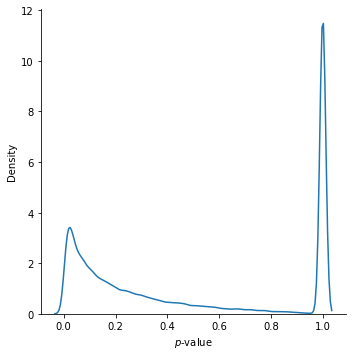

In [10]:
sns.displot(edge_pvals, x="pval", kind="kde", bw_adjust=.25)
plt.xlabel(u"$p$-value")
plt.show()

## Identifying Signal Vertices

In [ ]:
graspologic.embed.OmnibusEmbed

## Whole-brain Comparisons